# Abschlussprojekt - Diskriminierung in Machine Learning Modellen

Dieses Notebook analysiert den `adult.csv`-Datensatz unter besonderer Berücksichtigung von Fairness-Aspekten in Machine-Learning-Modellen.

### Zielsetzung:
- **Explorative Datenanalyse (EDA):** Siehe EDA-Notebook
- **Machine Learning Modelle:** Vergleich mehrerer Modelle hinsichtlich ihrer Vorhersagegenauigkeit und Fairness.
- **Fairness-Analyse:** Berechnung von Fairness-Metriken zur Bewertung der Diskriminierung.

In [8]:
# Import notwendiger Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os

from data_cleaning import fill_missing_values, rename_columns
from data_science_skript import preprocess_data, generate_plots

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
import time

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler


from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference, demographic_parity_ratio
from fairlearn.postprocessing import ThresholdOptimizer

# Sytle für Plots
plt.style.use("dark_background")
colors = ["silver", "teal"]

In [2]:
# Laden und aufbereiten der Daten
df = pd.read_csv(r"C:\Users\kimko\PortfolioProjekt\adult.csv", na_values=["?"]) 
df = fill_missing_values(df) 
df = rename_columns(df)

### Knappe Explorative Datenanalyse (EDA) hinsichtlich der Einkommensverteilung nach Geschlecht und Ethnie

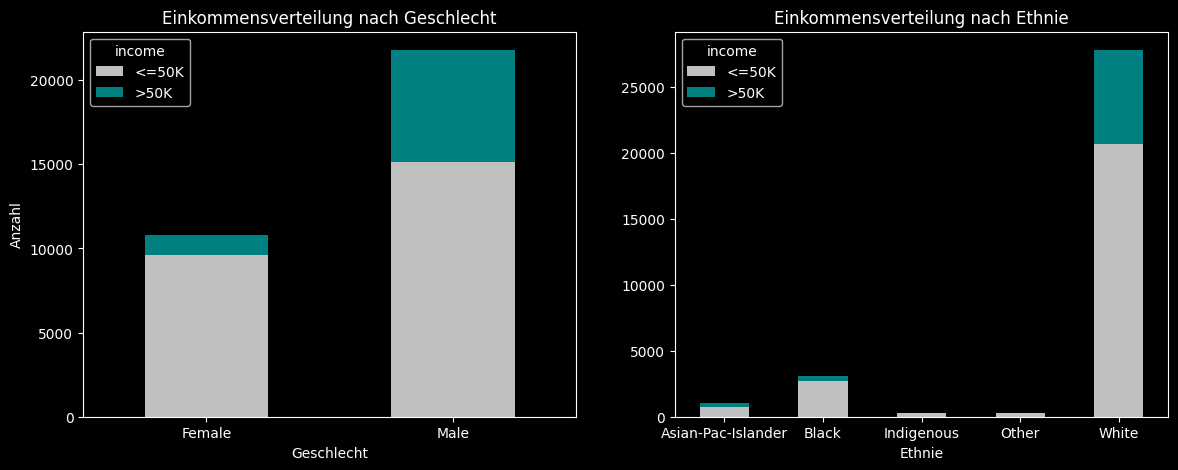

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Einkommensverteilung nach Geschlecht
df.groupby(["sex", "income"]).size().unstack().plot(kind="bar", stacked=True, color=colors, ax=ax[0])
ax[0].set_title("Einkommensverteilung nach Geschlecht")
ax[0].set_xlabel("Geschlecht")
ax[0].set_ylabel("Anzahl")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)

# Einkommensverteilung nach Ethnie
df.groupby(["race", "income"]).size().unstack().plot(kind="bar", stacked=True, color=colors, ax=ax[1])
ax[1].set_title("Einkommensverteilung nach Ethnie")
ax[1].set_xlabel("Ethnie")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

plt.show()

In [4]:
# Variablen umwandeln
df = preprocess_data(df)

File 'heatmap.png' already exists. Loading...


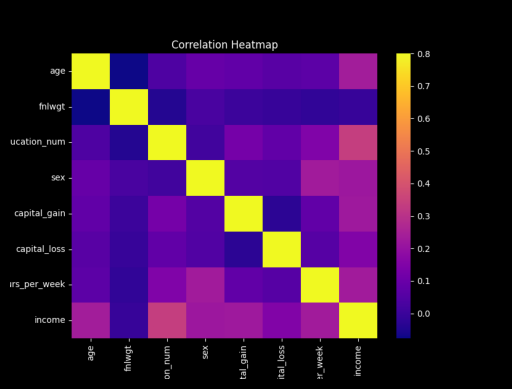

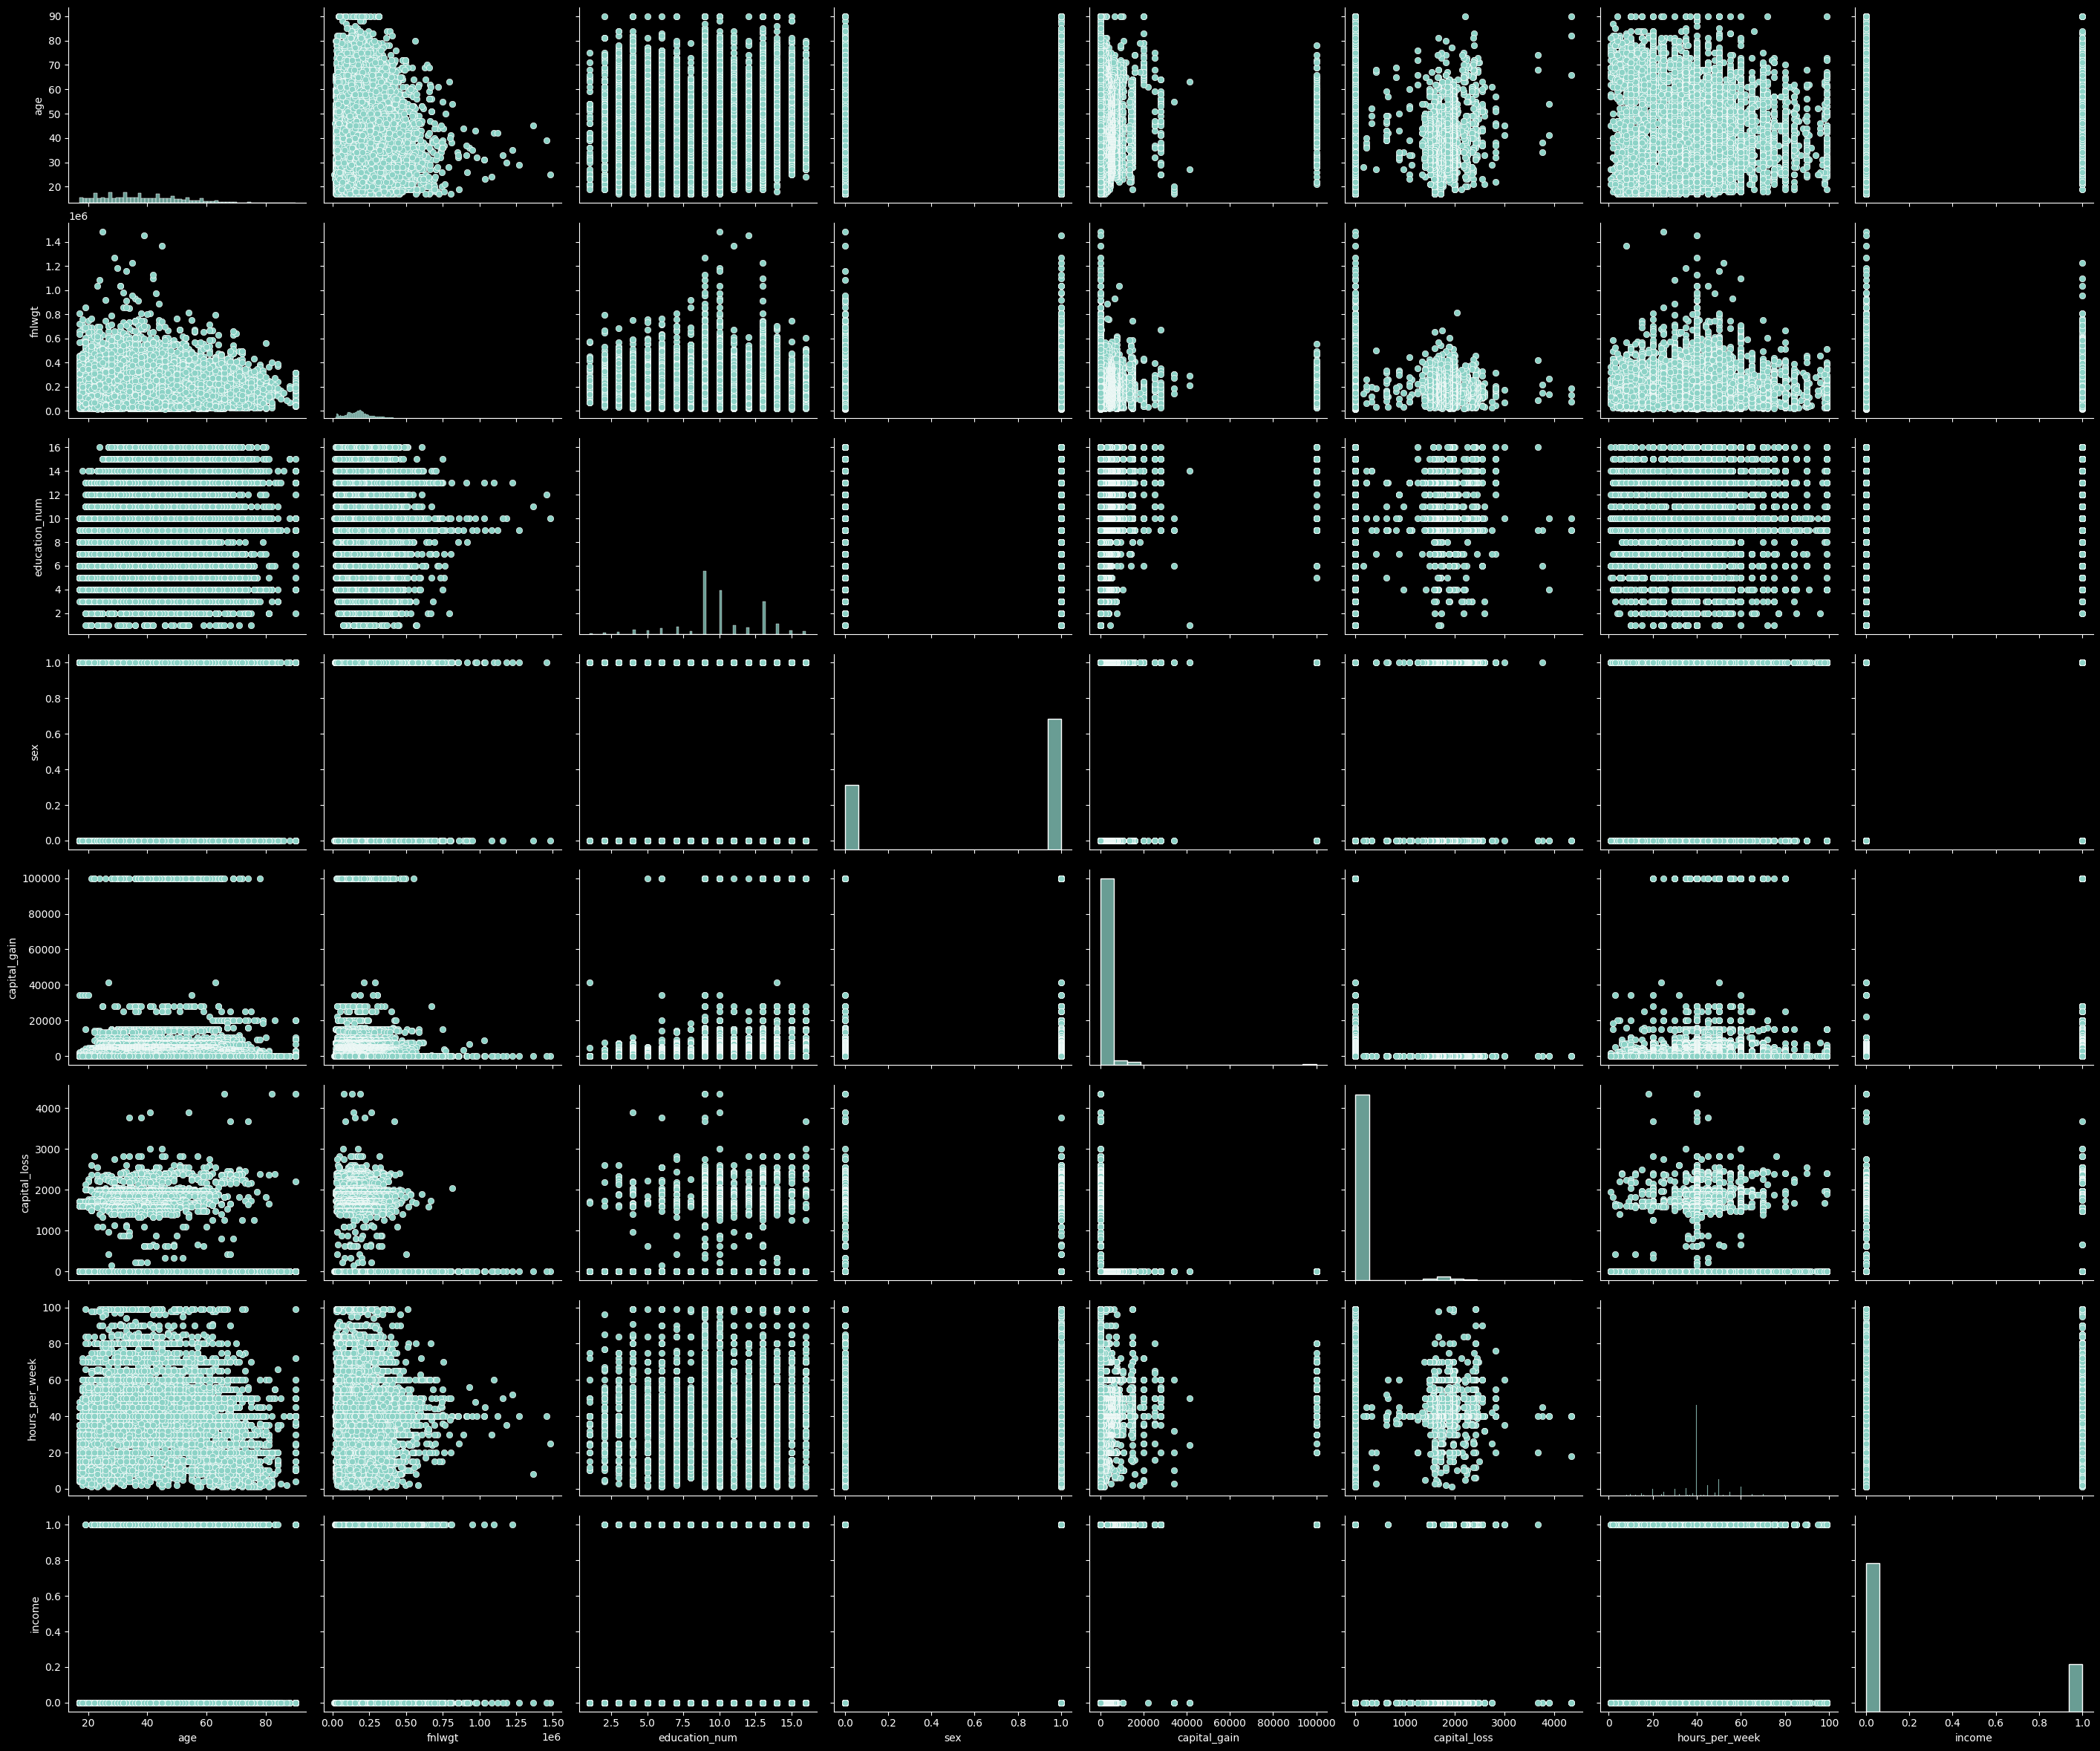

Pairplot saved as 'pairplot.png'


In [5]:
generate_plots(df) 

### Machine Learning Modelle

- Logistische Regression
- Decision Tree
- Random Forest

In [12]:
# Train-Test-Split
pickle_train_test = "data_science/train_test_split.pkl"

if os.path.exists(pickle_train_test):
    print("Lade bereits gespeicherte Trainings- und Testdaten...")
    with open(pickle_train_test, "rb") as file:
        features_train, features_test, target_train, target_test = pickle.load(file)
else:
    print("Erstelle neue Trainings- und Testdaten...")
    
    # Daten splitten
    target = df["income"]
    features = df.drop(columns=["income"])

    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.2, stratify=target, random_state=42
    )

    # Daten speichern
    with open(pickle_train_test, "wb") as file:
        pickle.dump((features_train, features_test, target_train, target_test), file)

    print("Daten wurden gespeichert!")

Lade bereits gespeicherte Trainings- und Testdaten...


In [13]:
print("Trainingsdaten:\n",features_train.shape)
print("\nTestdaten:\n",features_test.shape)

Trainingsdaten:
 (26048, 14)

Testdaten:
 (6513, 14)


In [ ]:
df.dtypes

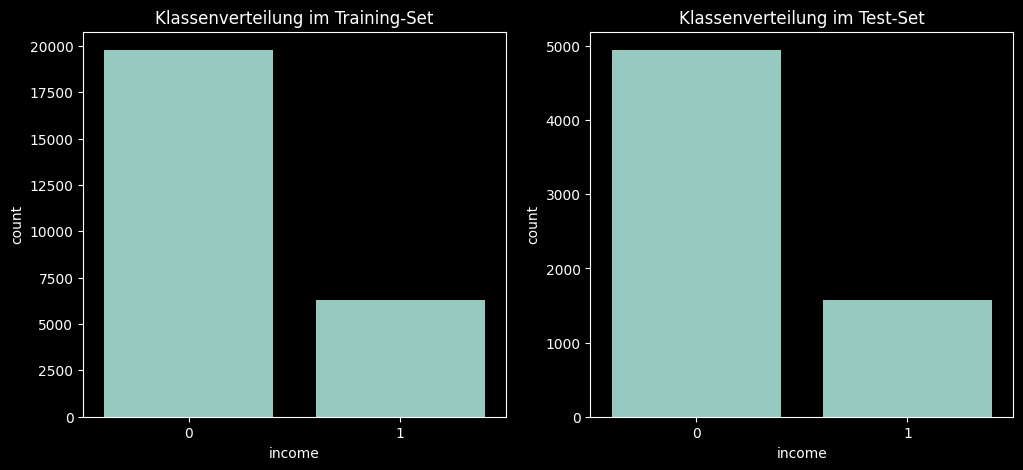

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=target_train, ax=ax[0])
ax[0].set_title("Klassenverteilung im Training-Set")

sns.countplot(x=target_test, ax=ax[1])
ax[1].set_title("Klassenverteilung im Test-Set")

plt.show()


In [15]:
train_crosstab_income = pd.crosstab(index=target_train, columns = "count", normalize = "columns")
test_crosstab_income = pd.crosstab(index=target_test, columns = "count", normalize = "columns")
display(train_crosstab_income)
display(test_crosstab_income)

col_0,count
income,
0,0.759175
1,0.240825


col_0,count
income,
0,0.759251
1,0.240749
